In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf

# Enable GPU memory growth if GPU is available
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("✅ GPU memory growth enabled.")
    except:
        print("⚠️ Could not set GPU memory growth.")
else:
    print("🖥️ Running on CPU.")


✅ GPU memory growth enabled.


In [3]:
# From SKlearns website
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    # Add text labels inside the boxes
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [4]:
# Organize data into train, valid, test dirs
os.chdir('data/Sign-Language-Digits-Dataset')
if os.path.isdir('train/0/') is False: 
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')

    for i in range(0, 10):
        shutil.move(f'{i}', 'train')
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')

        valid_samples = random.sample(os.listdir(f'train/{i}'), 30)
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}', f'valid/{i}')

        test_samples = random.sample(os.listdir(f'train/{i}'), 5)
        for k in test_samples:
            shutil.move(f'train/{i}/{k}', f'test/{i}')
os.chdir('../..') 

In [5]:
train_path = 'data/Sign-Language-Digits-Dataset/train'
valid_path = 'data/Sign-Language-Digits-Dataset/valid'
test_path = 'data/Sign-Language-Digits-Dataset/test'

In [6]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [7]:
assert train_batches.n == 1712
assert valid_batches.n == 300
assert test_batches.n == 50

# Modify Model

In [8]:
mobile = tf.keras.applications.mobilenet.MobileNet()

In [9]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [10]:
x = mobile.layers[-5].output

In [11]:
x = tf.keras.layers.Reshape(target_shape=(1024,))(x)
output = Dense(units=10, activation='softmax')(x)

In [12]:
model = Model(inputs=mobile.input, outputs=output)

In [13]:
for layer in model.layers[:-22]:
    layer.trainable = False

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [15]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
model.fit(x=train_batches,
            steps_per_epoch=len(train_batches),
            validation_data=valid_batches,
            validation_steps=len(valid_batches),
            epochs=30,
            verbose=2
)

Epoch 1/30
172/172 - 5s - loss: 0.5912 - accuracy: 0.8283 - val_loss: 0.2983 - val_accuracy: 0.9100 - 5s/epoch - 31ms/step
Epoch 2/30
172/172 - 2s - loss: 0.1125 - accuracy: 0.9866 - val_loss: 0.1335 - val_accuracy: 0.9600 - 2s/epoch - 13ms/step
Epoch 3/30
172/172 - 2s - loss: 0.0597 - accuracy: 0.9947 - val_loss: 0.0847 - val_accuracy: 0.9800 - 2s/epoch - 13ms/step
Epoch 4/30
172/172 - 2s - loss: 0.0321 - accuracy: 0.9982 - val_loss: 0.0577 - val_accuracy: 0.9933 - 2s/epoch - 13ms/step
Epoch 5/30
172/172 - 2s - loss: 0.0308 - accuracy: 0.9965 - val_loss: 0.0531 - val_accuracy: 0.9900 - 2s/epoch - 13ms/step
Epoch 6/30
172/172 - 2s - loss: 0.0181 - accuracy: 0.9988 - val_loss: 0.0416 - val_accuracy: 0.9933 - 2s/epoch - 13ms/step
Epoch 7/30
172/172 - 2s - loss: 0.0149 - accuracy: 0.9988 - val_loss: 0.0560 - val_accuracy: 0.9800 - 2s/epoch - 13ms/step
Epoch 8/30
172/172 - 2s - loss: 0.0124 - accuracy: 0.9977 - val_loss: 0.0485 - val_accuracy: 0.9867 - 2s/epoch - 13ms/step
Epoch 9/30
172/1

# Predict sign language digits

In [17]:
test_labels = test_batches.classes

In [18]:
prediction = model.predict(x=test_batches, verbose=0)

In [19]:
cm = confusion_matrix(y_true=test_labels, y_pred=prediction.argmax(axis=1))

In [20]:
test_batches.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 2 0 3 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 5]]


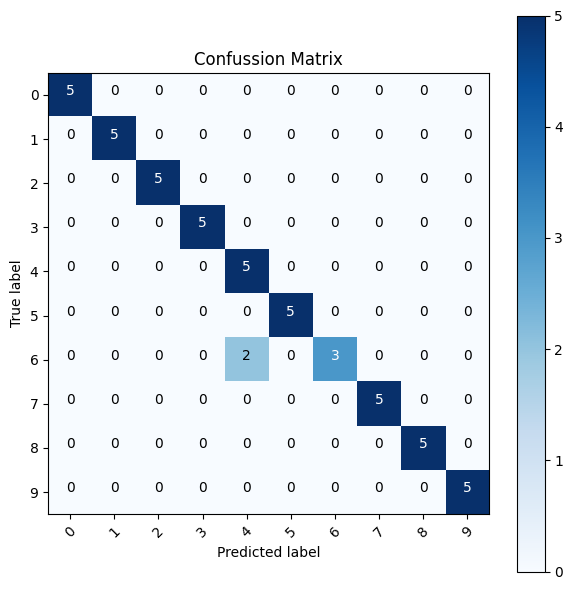

In [21]:
cm_plot_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confussion Matrix')